<a href="https://colab.research.google.com/github/RobDrie/ML-TS/blob/main/00_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home assignment

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A home assignment from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

## Problem statement

The dataset we are interested in here is called "TwoPatterns". It is described [in this page](http://www.timeseriesclassification.com/description.php?Dataset=TwoPatterns) and can be downloaded using `tslearn`'s `load_dataset` utility, as seen in previous labs.

You should load the data and analyze it under several angles:

1. visualize the dataset (or a few time series from the dataset) to understand whether you expect time-shift-invariant methods to perform well on this dataset or not ;
2. compare time-shift-invariant methods to their time-shift-sensitive counterparts for the following tasks, and conclude:
    * clustering ;
    * supervised classification ;
    * forecasting (suppose you have to forecast the second half of the series with the first half provided as input).

It is not asked here that you implement specific layers / methods by yourself, but rather that you use established implementations of the methods you need.
Your focus should rather be on:
* data visualization,
* model architecture (for deep networks),
* experiment design,
* result analysis

## Deadline

Deadline for this home assignment is February 23th, 2024.
You should use the link on moodle to hand in your assignment.
A single ipynb file should be provided,
with execution traces.
This assignment is to be done **by groups of two, at most** and names of both students should be included in the file name.

In [ ]:
!pip install tslearn
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.5 MB/s eta 0:00:00


# Section 1 Data Visualization

### Load the data and show the dimensions

In [7]:
from tslearn.datasets import UCR_UEA_datasets
from keras.utils import to_categorical

X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("TwoPatterns")
#print(X_train.shape)

y_train_cat = to_categorical(y_train - 1)
y_test_cat = to_categorical(y_test - 1)
print(f"X_train shape: {X_train.shape}, y_train.shape: {y_train.shape}, y_train_cat.shape: {y_train_cat.shape}, y_test_cat.shape: {y_test_cat.shape}")

num_categories = y_train_cat.shape[-1]

X_train shape: (1000, 128, 1), y_train.shape: (1000,), y_train_cat.shape: (1000, 4), y_test_cat.shape: (4000, 4)


### Plot a selection of time series for each class, together with the subplots

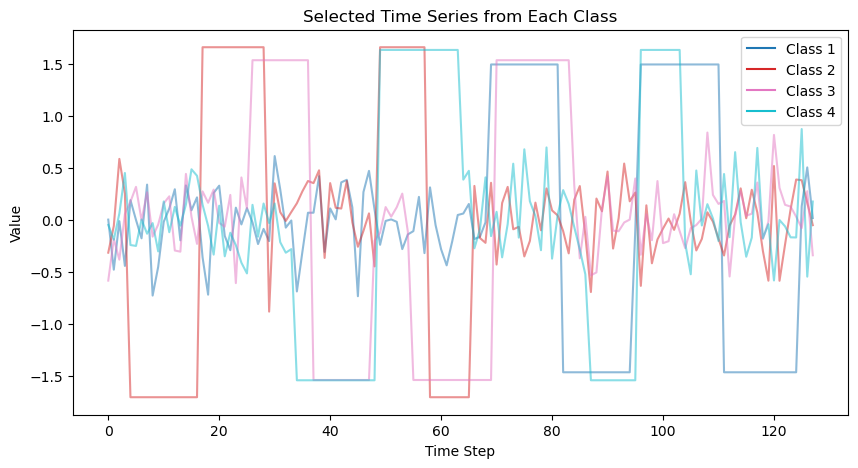

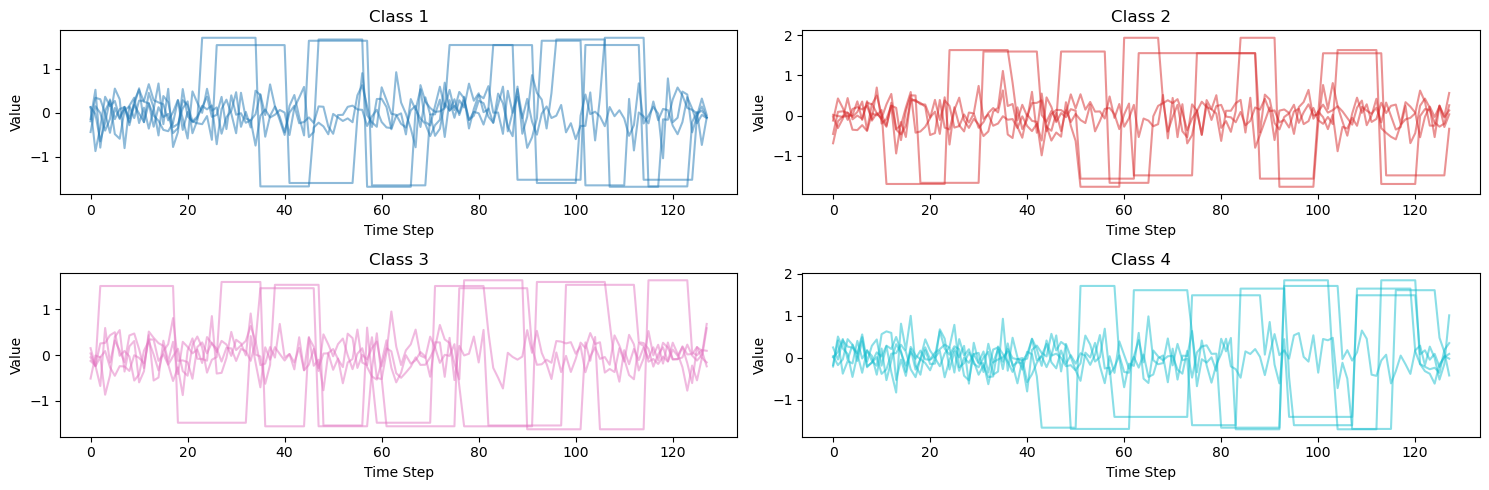

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_selected_classes(X_train, y_train, num_samples_per_class=10):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    fig, ax = plt.subplots(figsize=(10, 5))

    for idx, cls in enumerate(unique_classes):
        class_indices = np.where(y_train == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        # Plot all selected samples for this class at once
        for sample_idx in sample_indices:
            ax.plot(X_train[sample_idx], color=colors[idx], alpha=0.5)

        # Add a legend entry for this class
        ax.plot([], [], color=colors[idx], label=f'Class {cls}')

    ax.legend()
    plt.title('Selected Time Series from Each Class')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.show()


def plot_selected_classes_subplots(X_train, y_train, num_samples_per_class=10):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    # Calculate the number of rows needed for subplots based on the number of classes
    num_rows = int(np.ceil(num_classes / 2))  # Adjust the denominator to control how many columns you want
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 2.5), squeeze=False)

    for idx, cls in enumerate(unique_classes):
        class_indices = np.where(y_train == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)

        # Determine which subplot to use
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]

        for sample_idx in sample_indices:
            ax.plot(X_train[sample_idx], color=colors[idx], alpha=0.5)

        ax.set_title(f'Class {cls}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


plot_selected_classes(X_train, y_train, 1)
plot_selected_classes_subplots(X_train, y_train, 5)

### Question: Do we expect time-invariant methods to perform well on this dataset?

### Answer:
The time series for each class show noisy curves with sudden level increases at different times. There seems to be two types of curves within each class, one with many small variations around 0 and one with more stable values but with sharp level shifts. When comparing the different classes some patterns can be recognized in the time series with sharp level shifts, but observed at different time steps. Therefore, it is expected that time-shift invariant methods might be able to perform well in terms of clustering time series that are shifted across time. However, in terms of predictions, the time-shift sensitive methods are expected to perform better

In this report, the folloing metrics are analysed for the different methods:
-  Time-shift invariant method: soft-dtw
-  Time-shift sensitive method: euclidean

## Section 2 Comparing time-shift invariant and sensitive methods

The time-shift invariant and sensitive methods are compared on the following tasks:
* 2.1 clustering ;
* 2.2 supervised classification ;
* 2.3 forecasting ;





#### 2.1 TimeSeriesKMeans clustering with Euclidean distance metric and Soft-dtw distance metric

In [ ]:
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tqdm.notebook import tqdm
import multiprocessing

# Function to evaluate clustering quality
def evaluate_clustering(X_train_scaled, params):
    n_clusters = params['n_clusters']
    metrics = params['metric']
    gamma = params['gamma']

    # Fit the model and predict clusters in one step
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric=metrics, metric_params={"gamma": gamma}, n_jobs=multiprocessing.cpu_count() * 2 // 3, random_state=0)
    y_pred = km.fit_predict(X_train_scaled)

    # Compute the silhouette score
    score = silhouette_score(X_train_scaled, y_pred, metric=metrics, metric_params={"gamma": gamma})

    return {'n_clusters': n_clusters, 'gamma': gamma, 'score': score, 'metric': metrics}


In [ ]:
# Preprocess the time series data
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train)

sample_size = 50  # Adjust this value to your desired sample size
random_indices = np.random.choice(X_train_scaled.shape[0], sample_size, replace=False)
X_train_sample = X_train_scaled[random_indices]

# Define parameter grid for grid search
param_grid = [{'n_clusters': n_clusters, 'gamma': gamma, 'metric': metric} for n_clusters in range(2, 5) for gamma in [0.01, 0.1, 1, 10] for metric in ['euclidean', 'softdtw']]

# Perform grid search with tqdm progress bar using list comprehension
results = [evaluate_clustering(X_train_sample, params) for params in tqdm(param_grid, desc="Grid search progress")]


# Find the best parameters
best_params = max(results, key=lambda x: x['score'])
best_metric = best_params['metric']
best_n_clusters = best_params['n_clusters']
best_gamma = best_params['gamma']
best_score = best_params['score']

print(f"Best metric: {best_metric}")
print(f"Best number of clusters: {best_n_clusters}")
print(f"Best gamma for soft-DTW: {best_gamma}")
print(f"Best silhouette score: {best_score}")


Grid search progress:   0%|          | 0/24 [00:00<?, ?it/s]

Best metric: softdtw
Best number of clusters: 4
Best gamma for soft-DTW: 0.01
Best silhouette score: 0.6490733579159346


In [ ]:
# Fit the final model with the best parameters
final_km = TimeSeriesKMeans(n_clusters=best_n_clusters,
                            metric=best_metric,
                            metric_params={"gamma": best_gamma},
                            verbose=1,
                            random_state=0)
final_km.fit(X_train_sample)



# Fit a final model with the best number of clusters according to the euclidean distance
euclidean_results = [result for result in results if result['metric'] == 'euclidean']
best_params_euclidean = max(euclidean_results, key=lambda x: x['score'])
best_n_clusters_euclidean = best_params_euclidean['n_clusters']

final_km_euclidean = TimeSeriesKMeans(n_clusters= best_n_clusters_euclidean,
                            metric='euclidean',
                            metric_params={"gamma": best_gamma},
                            verbose=1,
                            random_state=0)
final_km_euclidean.fit(X_train_sample)




# Plot the barycenters
# plt.figure(figsize=(10, 5))
# for i in range(best_n_clusters):
#     plt.plot(final_km.cluster_centers_[i], label=f'Barycenter {i+1}')
# plt.legend()
# plt.title('Barycenters of the clusters')
# plt.xlabel('Time Step')
# plt.ylabel('Value')
# plt.show()

483.685 --> 100.270 --> 87.896 --> 79.768 --> 79.749 --> 79.753 --> 79.688 --> 79.691 --> 79.685 --> 79.671 --> 79.658 --> 79.613 --> 79.640 --> 79.581 --> 79.602 --> 79.561 --> 79.577 --> 79.550 --> 79.568 --> 79.546 --> 79.560 --> 79.546 --> 79.552 --> 79.542 --> 79.547 --> 79.539 --> 79.543 --> 79.537 --> 79.540 --> 79.535 --> 79.538 --> 79.533 --> 79.536 --> 79.532 --> 79.535 --> 79.531 --> 79.534 --> 79.530 --> 79.533 --> 79.529 --> 79.532 --> 79.529 --> 79.531 --> 79.528 --> 79.531 --> 79.528 --> 79.531 --> 79.528 --> 79.530 --> 79.528 --> 
179.599 --> 103.838 --> 102.610 --> 102.280 --> 102.280 --> 


TimeSeriesKMeans(metric_params={'gamma': 0.01}, random_state=0, verbose=1)

### Visualization of the results for Soft-dtw and Euclidean centers and


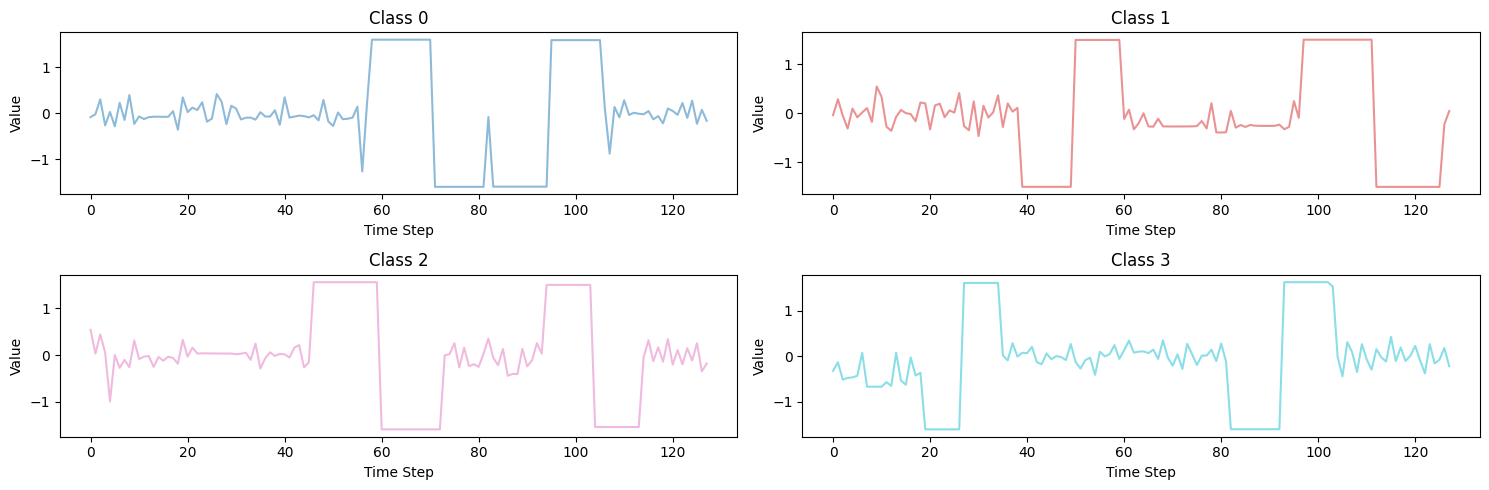

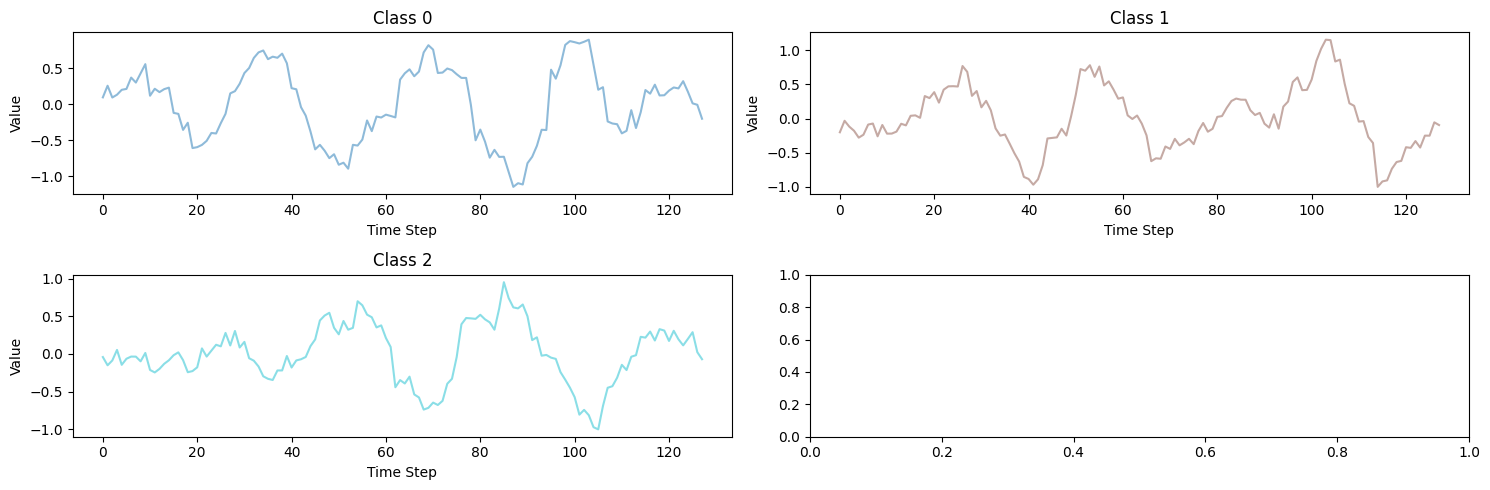

In [ ]:
# Centers obtained by fitting a model with the best parameters as found with the soft-dtw metric
plot_selected_classes_subplots(final_km.cluster_centers_, list(range(final_km.n_clusters)), 1)

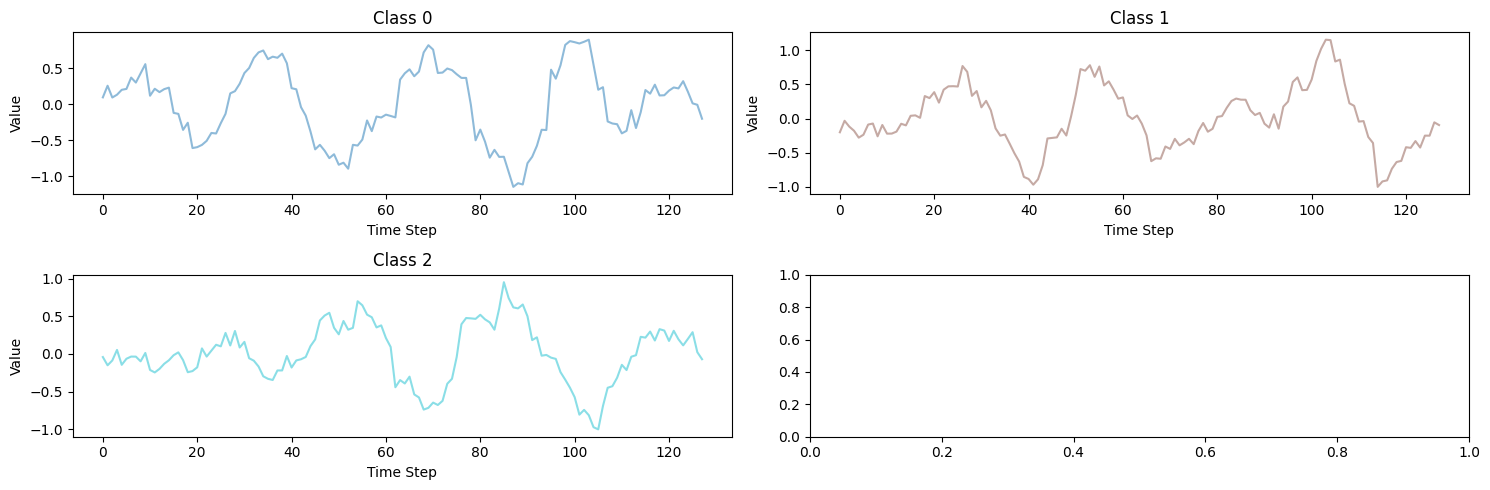

In [ ]:
# Centers obtained by fitting a model with the best parameters as found with the Euclidean metric
plot_selected_classes_subplots(final_km_euclidean.cluster_centers_, list(range(final_km_euclidean.n_clusters)), 1)


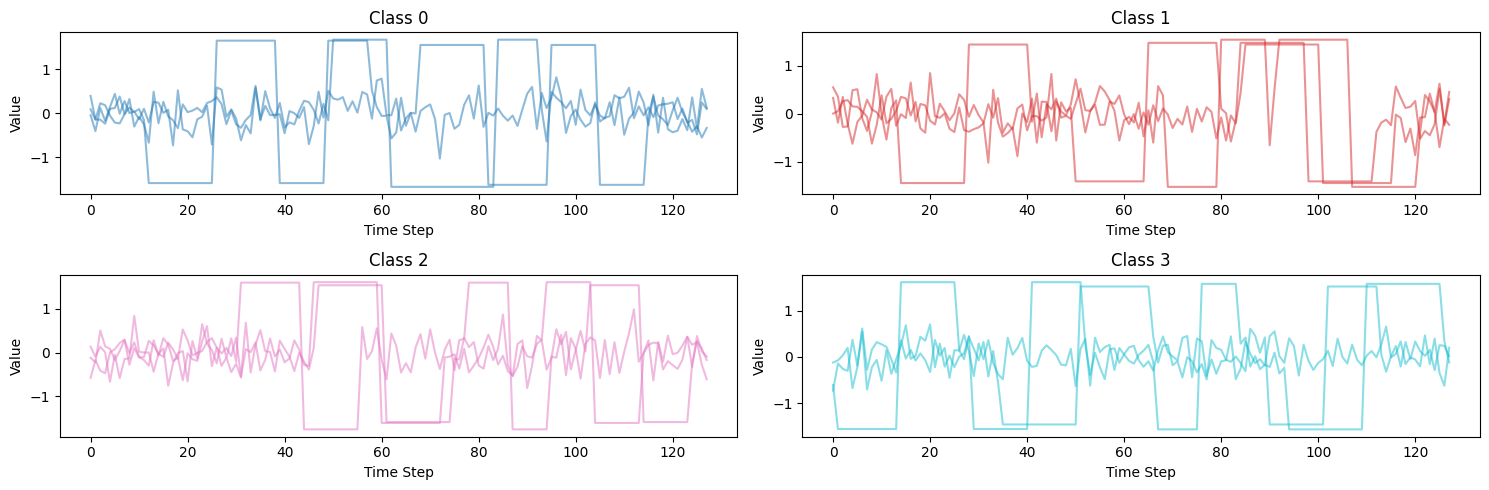

In [ ]:
# Subset of the clustering as obtained with the best soft-dtw parameters
plot_selected_classes_subplots(X_train_sample, final_km.labels_, 3)

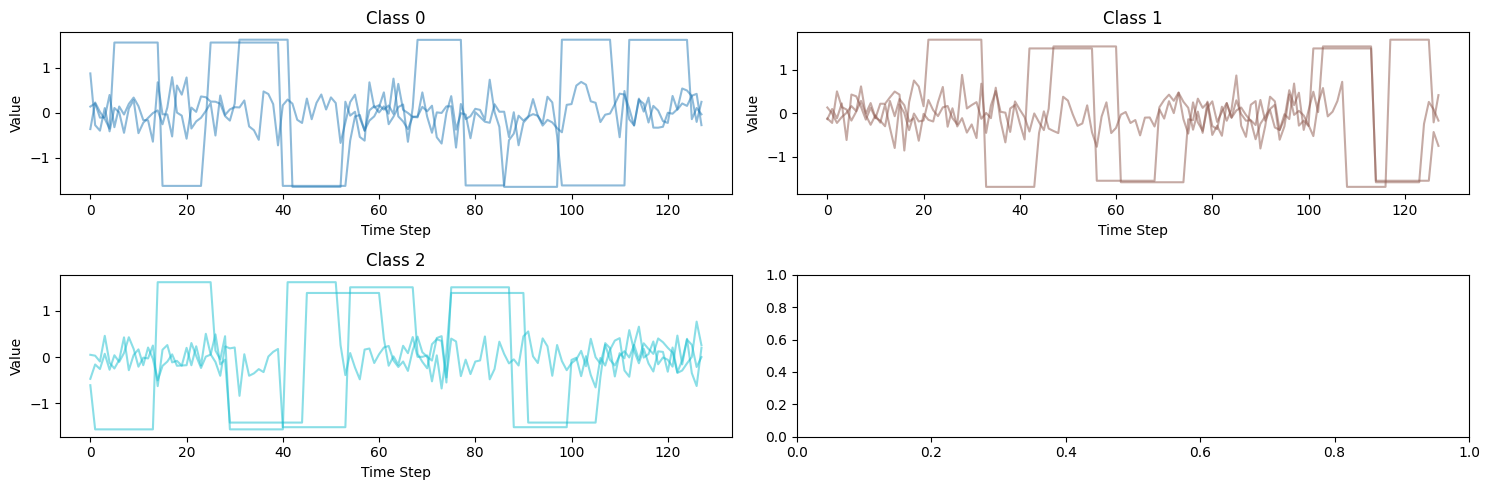

In [ ]:
# Subset of the clustering as obtained with the Euclidean metric
plot_selected_classes_subplots(X_train_sample, final_km_euclidean.labels_, 3)

### 2.2 Supervised classification

#### **Experimental design**
For the classification of the time series, three architectures are examined which are:
* CNN with(out) attention
* LSTM with(out) attention
* Transformer

The classifiers are trained using the CategoricalCrossEntropy loss and the performances of the classifiers are compared using the accuracy scores.
Additionally, we implemented some skip connections. These residual connections allow the input of a layer to be added to its output. It helps to mitigate the vanishing gradient problem. Residual connections enable the construction of deeper models without the risk of training stagnation due to the vanishing gradient.


CNNs, LSTMs, and Transformer models effectively evaluate time-series classification methods. Each architecture has unique characteristics that make it suitable for handling time-series data, strengths, and limitations in capturing temporal patterns and dependencies.

##### **CNN (Convolutional Neural Networks)**
- **Feature Extraction**: CNNs excel at automatically detecting important features. These networks can identify local patterns in the time series, such as trends and seasonality.
- **Hierarchical Pattern Learning**: The layered structure enables it to learn hierarchical representations. Early layers may detect simple patterns, while deeper layers can identify more complex sequences of patterns.
- **Efficiency**: CNNs are computationally efficient, especially for data where relevant features are local.

##### **LSTM (Long Short-Term Memory Networks)**
- **Temporal Dependencies**: LSTMs capture long-term dependencies, which is valuable for time series where the impact of a previous event may extend far into the future.
- **Sequence-to-Sequence Learning**: Unlike CNNs that treat the input data as fixed-size blocks, LSTMs process data in sequences suited for time series analysis where the order and timing of data points are critical.
- **Flexibility in Sequence Length**: LSTMs can (theoretically, but not with keras) handle variable-length input sequences.

##### **Why Apply Attention?**
- **Improved Interpretability**: Attention layers can provide insights into which parts are emphasized when making predictions, presenting a form of interpretability.
- **Adaptability**: Attention allows models to adapt their focus over different parts of the input data. It is beneficial when the relevance of specific data points can vary over time.

##### **Transformer**
- **Attention Mechanism**: The key innovation of Transformer models is the attention mechanism, which allows the model to weigh the importance of different parts of the input sequence when making predictions.
- **Parallel Processing**: Unlike LSTMs that process data sequentially, Transformers can process entire sequences simultaneously.
- **Global Perspective**: By evaluating the entire data sequence in unison, Transformers capture global dependencies, offering a comprehensive understanding that surpasses previous models' reach.

## CNN with(out) attention


In [9]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras import Sequential

def create_cnn_attention_model(input_shape, num_categories, conv_configs, dense_units, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs

    for config in conv_configs:
        filters = config['filters']
        kernel_size = config['kernel_size']
        x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)

        if config.get('attention'):
            # Reshape for attention if necessary. Attention requires the input shape as (batch_size, sequence, features).
            # After Conv1D and Pooling layers, the shape should already be compatible.
            query = value = x
            attention = MultiHeadAttention(num_heads=config['attention']['num_heads'],
                                            key_dim=config['attention']['key_dim'],
                                            dropout=dropout_rate)(query, value, value)
            x = LayerNormalization(epsilon=1e-6)(attention + x)  # Applying residual connection
            x = Dropout(dropout_rate)(x)

    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_categories, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
from sklearn.model_selection import train_test_split

# First architecture: small kernel_size
configs0 = [
    {'filters': 64, 'kernel_size': 5},
    {'filters': 128, 'kernel_size': 5},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 5}  # Conv layer followed by attention
]
dense_units0 = 64

configs1 = [
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 5},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]
dense_units1 = 64

# Second architecture: large kernel_size
configs2 = [
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 10},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]
dense_units2 = 128

# Third architecture: large kernel_size
configs3 = [
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 5},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 5, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]
dense_units3 = 64

# Fourth architecture: large kernel_size
configs4 = [
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'filters': 128, 'kernel_size': 10},  # Conv layer without attention
    {'filters': 64, 'kernel_size': 10, 'attention': {'num_heads': 2, 'key_dim': 64}}  # Conv layer followed by attention
]
dense_units4 = 128


# Run training procedure on the different model configurations on train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=0)

configurations = [[configs0, dense_units0], [configs1, dense_units1], [configs2, dense_units2], [configs3, dense_units3], [configs4, dense_units4]]

validation_loss = []
validation_accuracy = []
history = []

for conv_configs, dense_units in configurations:
    cnn_attention_model = create_cnn_attention_model(X_train[0].shape, num_categories, conv_configs, dense_units=dense_units)
    cnn_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_cnn = cnn_attention_model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=20)
    loss, accuracy = cnn_attention_model.evaluate(X_val_split, y_val_split)
    validation_loss.append(loss)
    validation_accuracy.append(accuracy)
    history.append(history_cnn)

# Find model configuration with best validation accuracy
max_index = validation_accuracy.index(max(validation_accuracy))
print(f"The best model corresponds to configuration {max_index}, with validation_accuracy {max(validation_accuracy)}")
conv_configs = configurations[max_index][0]
dense_units = configurations[max_index][1]

# Retrain model with best configuration
cnn_attention_model = create_cnn_attention_model(X_train[0].shape, num_categories, conv_configs, dense_units=dense_units)
cnn_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn = cnn_attention_model.fit(X_train, y_train_cat, epochs=20)
test_loss, test_accuracy = cnn_attention_model.evaluate(X_test, y_test_cat)
print(f"The accuracy on the test set by the CNN model is given by: {test_accuracy}")


# cnn_attention_model = create_cnn_attention_model(X_train[0].shape, num_categories, conv_configs, dense_units = 50)
# cnn_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# #history_cnn = cnn_attention_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)
# history_cnn = cnn_attention_model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=100)

# cnn_attention_model.summary()


# test_loss, test_accuracy = cnn_attention_model.evaluate(X_test, y_test_cat)

# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


Epoch 1/20


2024-02-23 20:24:10.244279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 20:24:10.351987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 20:24:10.352260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:15 3s/step - accuracy: 0.2500 - loss: 1.3774

I0000 00:00:1708716253.750426   23089 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.3428 - loss: 1.3232 - val_accuracy: 0.6600 - val_loss: 0.9407
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7765 - loss: 0.6581 - val_accuracy: 0.9550 - val_loss: 0.1822
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9674 - loss: 0.1332 - val_accuracy: 0.9800 - val_loss: 0.0371
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0370 - val_accuracy: 0.9900 - val_loss: 0.0190
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.0110
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.8702e-04 - val_accuracy: 0.9950 - val_loss: 0.006

#### Visualization of the training and validation accuracy for baseline model without attention and other model configurations with different numbers of units and filter-size.

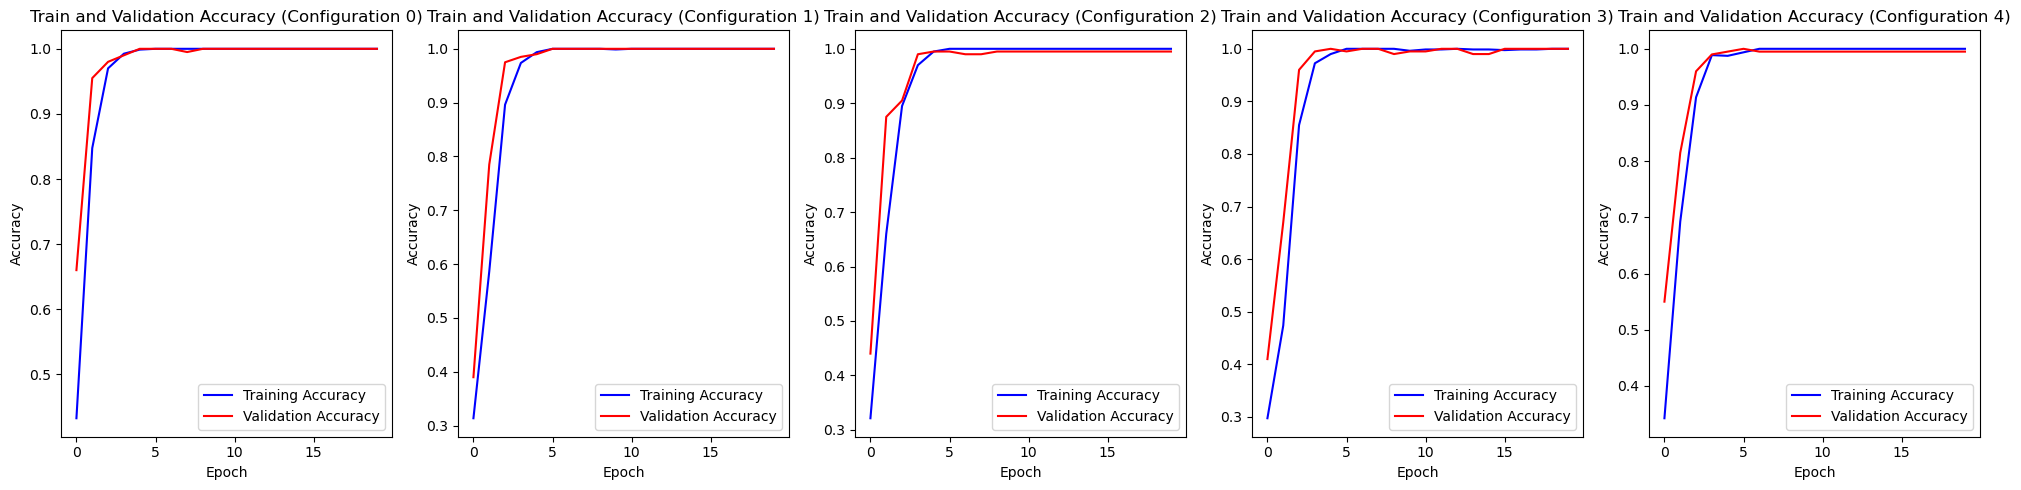

In [11]:
# Create subplots
fig, axs = plt.subplots(1, len(configurations), figsize=(20, 5))

# Iterate through history objects and plot
for i in range(len(configurations)):
    axs[i].plot(history[i].history['accuracy'], label='Training Accuracy', color='blue')
    axs[i].plot(history[i].history['val_accuracy'], label='Validation Accuracy', color='red')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_title(f'Train and Validation Accuracy (Configuration {i})')
    axs[i].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### LSTM with(out) attention

In [21]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras import Sequential

def create_lstm_attention_model(input_shape, num_categories, lstm_configs, dense_units, dropout_rate=0.1):
    dense_units = dense_units
    inputs = Input(shape=input_shape)
    x = inputs

    for i, config in enumerate(lstm_configs):
        lstm_units = config['units']
        return_sequences = True if i < len(lstm_configs) - 1 else False
        x = LSTM(lstm_units, return_sequences=return_sequences)(x)

        if config.get('attention'):
            # Assuming the attention layer is applied after the LSTM layer
            if return_sequences:
                # MultiHeadAttention expects inputs as (batch_size, sequence_length, features),
                # which matches the output shape of LSTM with return_sequences=True
                query = value = x
                attention = MultiHeadAttention(num_heads=config['attention']['num_heads'],
                                                key_dim=config['attention']['key_dim'],
                                                dropout=dropout_rate)(query, value, value)
                x = LayerNormalization(epsilon=1e-6)(attention + x)  # Applying residual connection
                x = Dropout(dropout_rate)(x)

    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_categories, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [22]:
lstm_configs0 = [
    {'units': 64},
    {'units': 64},  # LSTM layer without attention
    {'units': 32}  # LSTM layer followed by attention
]
dense_units0 = 64

lstm_configs1 = [
    {'units': 64, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'units': 64},  # LSTM layer without attention
    {'units': 32, 'attention': {'num_heads': 2, 'key_dim': 32}}  # LSTM layer followed by attention
]
dense_units1 = 64

lstm_configs2 = [
    {'units': 64, 'attention': {'num_heads': 2, 'key_dim': 64}},
    {'units': 64},  # LSTM layer without attention
    {'units': 32, 'attention': {'num_heads': 2, 'key_dim': 32}}  # LSTM layer followed by attention
]
dense_units2 = 128


configurations_lstm = [[lstm_configs0, dense_units0], [lstm_configs1, dense_units1], [lstm_configs2, dense_units2]]

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=0)

lstm_validation_loss = []
lstm_validation_accuracy = []
lstm_history = []
for conv_configs, dense_units in configurations_lstm:
    lstm_attention_model = create_lstm_attention_model(X_train[0].shape, num_categories, conv_configs, dense_units=dense_units)
    lstm_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_lstm = lstm_attention_model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=20)
    loss, accuracy = lstm_attention_model.evaluate(X_val_split, y_val_split)
    lstm_validation_loss.append(loss)
    lstm_validation_accuracy.append(accuracy)
    lstm_history.append(history_lstm)

# Find model configuration with best validation accuracy
max_index = lstm_validation_accuracy.index(max(lstm_validation_accuracy))
print(f"The best model corresponds to configuration {max_index}, with validation_accuracy {max(lstm_validation_accuracy)}")
conv_configs = configurations_lstm[max_index][0]
dense_units = configurations_lstm[max_index][1]


# Retrain model with best configuration
lstm_attention_model = create_lstm_attention_model(X_train[0].shape, num_categories, conv_configs, dense_units=dense_units)
lstm_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_lstm = lstm_attention_model.fit(X_train, y_train_cat, epochs=20)
test_loss, test_accuracy = lstm_attention_model.evaluate(X_test, y_test_cat)
print(f"The accuracy on the test set by the LSTM model is given by: {test_accuracy}")


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4385 - loss: 1.2756 - val_accuracy: 0.5300 - val_loss: 0.8602
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4943 - loss: 0.8244 - val_accuracy: 0.5650 - val_loss: 0.6987
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5550 - loss: 0.7215 - val_accuracy: 0.6000 - val_loss: 0.6656
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5626 - loss: 0.6948 - val_accuracy: 0.6100 - val_loss: 0.7234
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6983 - loss: 0.6479 - val_accuracy: 0.8200 - val_loss: 0.4318
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8496 - loss: 0.3638 - val_accuracy: 0.8100 - val_loss: 0.3434
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8958 - loss: 0.2671 - val_accuracy: 0.9500 - val_loss: 0.2315
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9279 - loss: 0.2843 - val_accuracy: 0.9600 - v

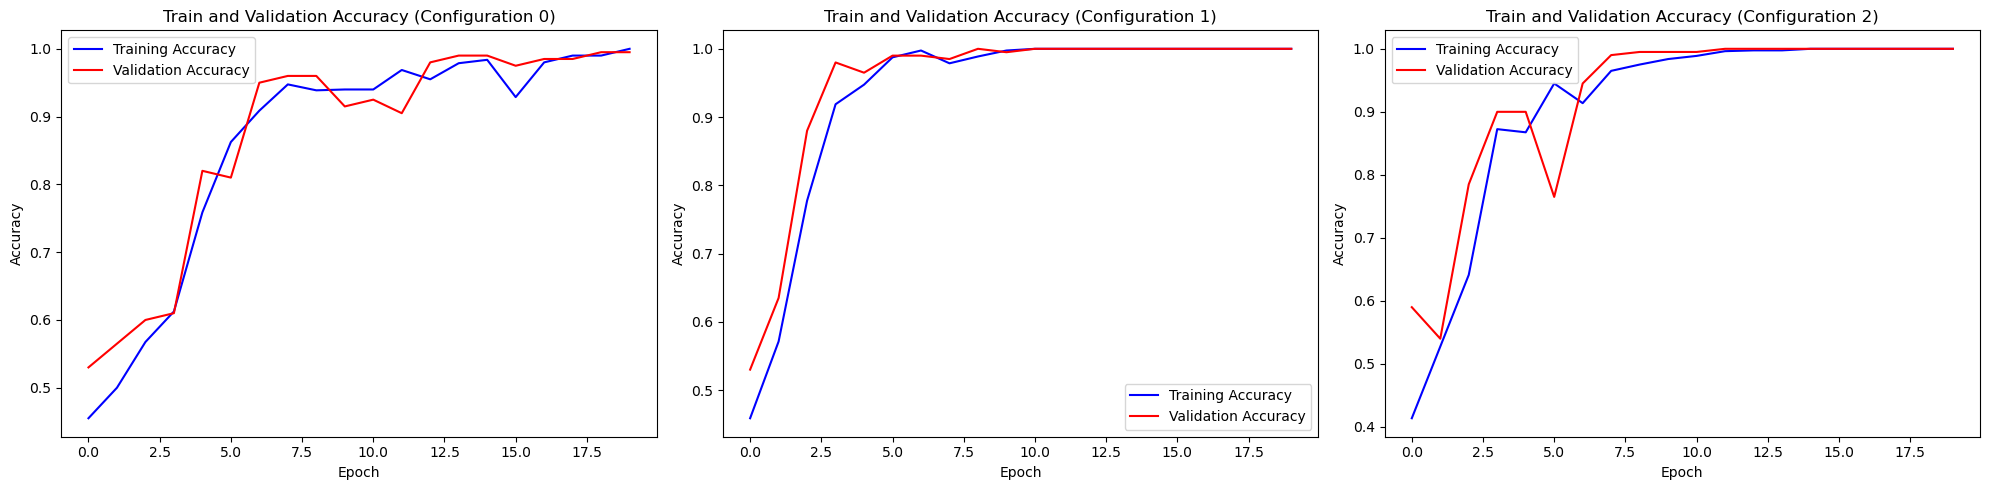

In [23]:
# Create subplots
fig, axs = plt.subplots(1, len(configurations_lstm), figsize=(20, 5))

# Iterate through history objects and plot
for i in range(len(configurations_lstm)):
    axs[i].plot(lstm_history[i].history['accuracy'], label='Training Accuracy', color='blue')
    axs[i].plot(lstm_history[i].history['val_accuracy'], label='Validation Accuracy', color='red')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_title(f'Train and Validation Accuracy (Configuration {i})')
    axs[i].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Transformer model

In [24]:
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
import keras

def create_transformer_model(input_shape, num_categories, num_layers, num_heads, d_model=64, dff=256, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    num_layers = num_layers
    num_heads = num_heads

    # Initial projection of input to the desired dimension (d_model)
    x = Dense(d_model)(inputs)

    for _ in range(num_layers):
        # Multi-head attention
        attn_output = MultiHeadAttention(num_heads, key_dim=d_model, dropout=dropout_rate)(x, x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        # Add & Norm (with residual connection)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feed-forward network
        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        # Add & Norm (with residual connection)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Pooling layer to reduce the sequence dimension
    pooled_output = GlobalAveragePooling1D()(x)

    # Output layer for classification
    outputs = Dense(num_categories, activation='softmax')(pooled_output)

    model = Model(inputs, outputs)
    return model

In [25]:
config1 = [{'layers': 3, 'num_heads': 4}]
config2 = [{'layers': 2, 'num_heads': 2}]
config3 = [{'layers': 2, 'num_heads': 2}]

configurations_transformers = [config1, config2, config3]

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=0)

transformers_validation_loss = []
transformers_validation_accuracy = []
transformers_history = []

for config in configurations_transformers:
    num_layers = config[0]['layers']
    num_heads = config[0]['num_heads']

    transformer_model = create_transformer_model(X_train[0].shape, num_categories, num_layers=num_layers, num_heads=num_heads)
    transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_transformer = transformer_model.fit(X_train_split, y_train_split, validation_data=(X_val_split, y_val_split), epochs=20)
    loss, accuracy = transformer_model.evaluate(X_val_split, y_val_split)
    transformers_validation_loss.append(loss)
    transformers_validation_accuracy.append(accuracy)
    transformers_history.append(history_transformer)


# Find model configuration with best validation accuracy
max_index = transformers_validation_accuracy.index(max(transformers_validation_accuracy))
print(f"The best model corresponds to configuration {max_index}, with validation_accuracy {max(transformers_validation_accuracy)}")
layers = configurations_transformers[max_index][0]['layers']
num_heads = configurations_transformers[max_index][0]['num_heads']


# Retrain model with best configuration
transformer_model = create_transformer_model(X_train[0].shape, num_categories, num_layers=layers, num_heads=num_heads)
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_transformer = transformer_model.fit(X_train, y_train_cat, epochs=20)
test_loss, test_accuracy = transformer_model.evaluate(X_test, y_test_cat)
print(f"The accuracy on the test set by the transformer model is given by: {test_accuracy}")


# transformer_model = create_transformer_model(X_train[0].shape, num_categories, num_layers=1)
# transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# transformer_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100)
# transformer_model.summary()

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.2390 - loss: 1.7693 - val_accuracy: 0.2150 - val_loss: 1.4093
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2374 - loss: 1.4302 - val_accuracy: 0.2450 - val_loss: 1.4775
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2465 - loss: 1.4545 - val_accuracy: 0.2300 - val_loss: 1.4120
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3164 - loss: 1.3881 - val_accuracy: 0.2300 - val_loss: 1.4280
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2855 - loss: 1.3892 - val_accuracy: 0.2900 - val_loss: 1.3725
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2892 - loss: 1.3862 - val_accuracy: 0.2700 - val_loss: 1.3929
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2959 - loss: 1.4050 - val_accuracy: 0.2950 - val_loss: 1.3705
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3348 - loss: 1.3716 - val_accuracy: 0.2950 - 

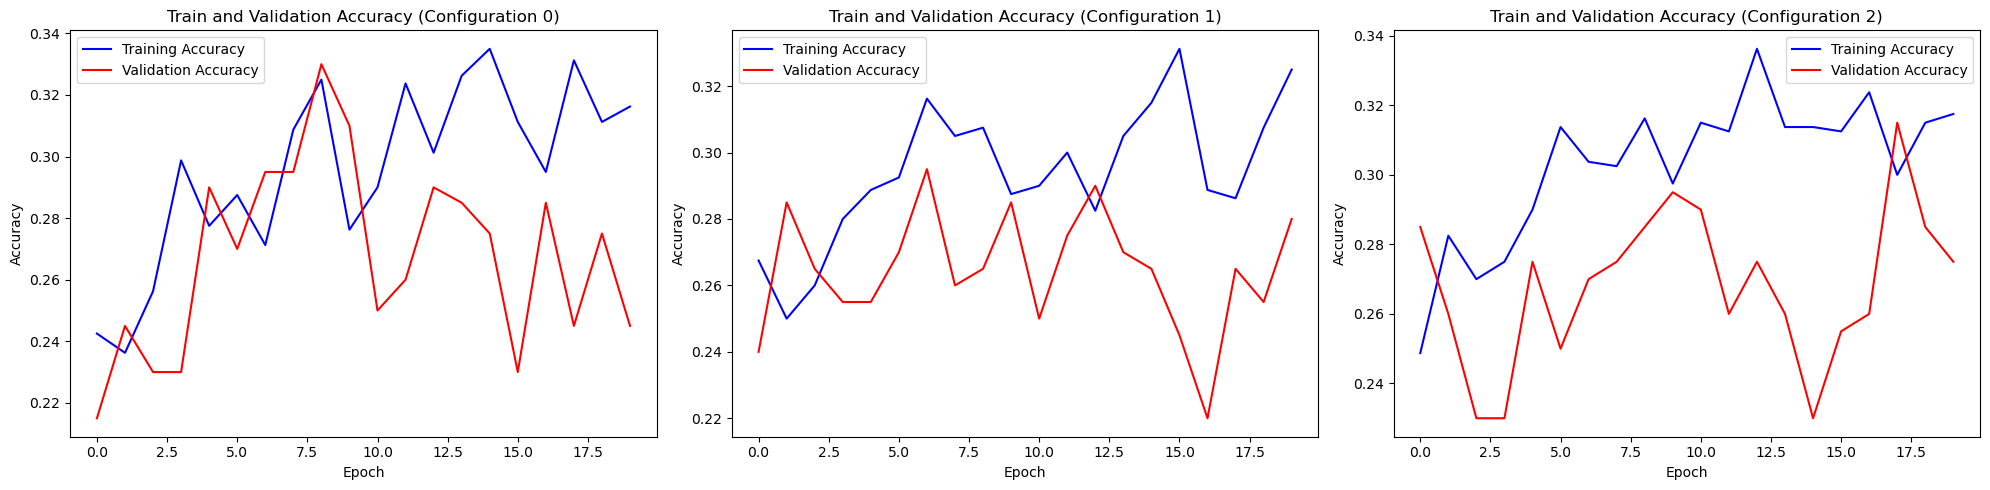

In [26]:
# Create subplots
fig, axs = plt.subplots(1, len(configurations_transformers), figsize=(20, 5))

# Iterate through history objects and plot
for i in range(len(configurations_transformers)):
    axs[i].plot(transformers_history[i].history['accuracy'], label='Training Accuracy', color='blue')
    axs[i].plot(transformers_history[i].history['val_accuracy'], label='Validation Accuracy', color='red')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_title(f'Train and Validation Accuracy (Configuration {i})')
    axs[i].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Section 2.3 Forecasting

For the assignment's forecasting, we explore LSTM and Transformer models to forecast the second half of the time series.

### Implementation Details

- **Encoding Context**: LSTM and Transformer models start by encoding the context (the first half of the time series). The LSTM processes each timestep sequentially, getting a representation of the sequence. In contrast, the Transformer uses self-attention to analyze the entire sequence simultaneously.
  
- **Forecasting Mechanism**:
  - **LSTM**: The LSTM model uses the `RepeatVector` to duplicate the encoded context for each forecasted timestep. This approach reuses the learned context, with the decoder sequentially generating the forecast based on this repeated context.
  - **Transformer**: The self-attention mechanisms allow the model to allocate focus dynamically across different segments. It improves the model's ability to capture complicated temporal patterns.

### Why Not CNN or Seq2Seq?
- **CNNs**: Convolutional Neural Networks (CNNs) are great at identifying patterns within a specific region. However, when forecasting tasks that require understanding long-term temporal dependencies, LSTM and Transformer models are preferred due to their capability of capturing both local and global dynamics of time series more effectively.

- **Seq2Seq Models**: While seq2seq models are powerful for various tasks such as sequence translation, they may not be necessary for simple forecasting. Furthermore, its implementation, especially with custom attention mechanisms, can be more complex and less straightforward in Keras than LSTM and Transformer models. This complexity, coupled with the direct forecasting nature of our task, makes LSTM and Transformer models more practical choices for this assignment.

In [18]:
import numpy as np

def prepare_forecasting_data(X, t):
    """
    Prepares training data for forecasting the next T-t timesteps from the first t timesteps.

    Parameters:
    - X: numpy array of shape (n_series, T, n_features), original dataset.
    - t: int, number of timesteps to use as input.

    Returns:
    - X_input: Input data consisting of the first t timesteps from each series.
    - X_target: Target data consisting of the next T-t timesteps from each series.
    """
    X_input = X[:, :t, :]
    X_target = X[:, t:, :]

    return X_input, X_target

# Example usage
t = 64  # Number of timesteps given as input

X_train_split, X_val_split = train_test_split(X_train, test_size=0.2, random_state=0)

X_train_input, X_train_target = prepare_forecasting_data(X_train_split, t)
X_val_input, X_val_target = prepare_forecasting_data(X_val_split, t)
X_test_input, X_test_target = prepare_forecasting_data(X_test, t)

print("Training input shape:", X_train_input.shape)
print("Training target shape:", X_train_target.shape)
print("Val input shape:", X_val_input.shape)
print("Val target shape:", X_val_target.shape)
print("Testing input shape:", X_test_input.shape)
print("Testing target shape:", X_test_target.shape)


Training input shape: (800, 64, 1)
Training target shape: (800, 64, 1)
Val input shape: (200, 64, 1)
Val target shape: (200, 64, 1)
Testing input shape: (4000, 64, 1)
Testing target shape: (4000, 64, 1)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.2144 - mae: 0.8748 - val_loss: 1.1302 - val_mae: 0.8533
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1827 - mae: 0.8679 - val_loss: 1.1225 - val_mae: 0.8538
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1531 - mae: 0.8537 - val_loss: 1.1136 - val_mae: 0.8481
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1485 - mae: 0.8500 - val_loss: 1.1200 - val_mae: 0.8480
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1421 - mae: 0.8438 - val_loss: 1.1098 - val_mae: 0.8404
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1275 - mae: 0.8363 - val_loss: 1.1046 - val_mae: 0.8422
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1296 - mae: 0.8383 - val_loss: 1.1106 - val_mae: 0.8423
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1080 - mae: 0.8264 - val_loss: 1.0997 - val_mae: 0.8322
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1094 - 

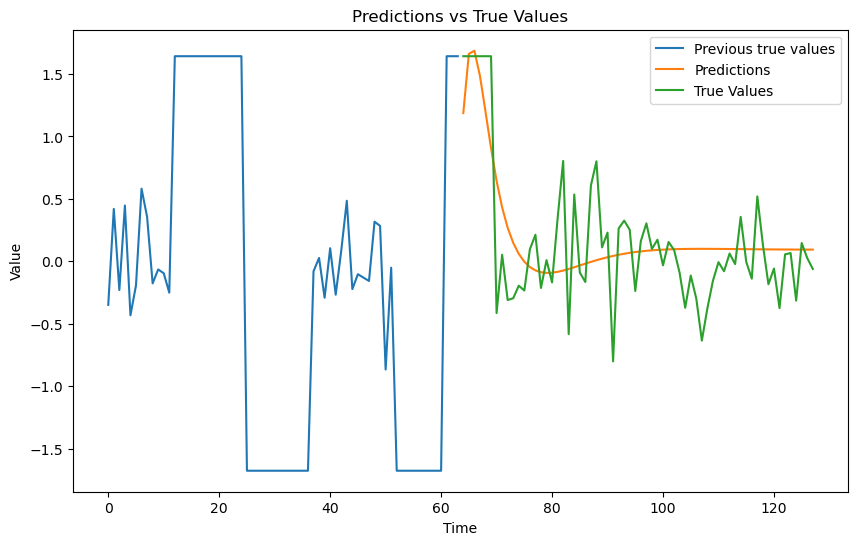

In [19]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.metrics import mean_absolute_error

def create_forecasting_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    encoded = LSTM(128, return_sequences=False)(inputs)
    # Repeat the encoding for each time step
    repeated_encoding = RepeatVector(output_shape[0])(encoded)
    # Decoder
    decoded = LSTM(128, return_sequences=True)(repeated_encoding)
    # TimeDistributed layer for output
    outputs = TimeDistributed(Dense(output_shape[1]))(decoded)

    model = Model(inputs, outputs)
    return model

# Example usage
t = 64  # Let's say we're given the first 64 steps and need to predict the next 64
forecasting_lstm_model = create_forecasting_lstm_model(X_train_input.shape[1:], X_train_target.shape[1:])
forecasting_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
forecasting_lstm_model.fit(X_train_input, X_train_target, validation_data=(X_val_input, X_val_target), epochs=20)
#forecasting_lstm_model.summary()


predictions = forecasting_lstm_model.predict(X_test_input)
results = forecasting_lstm_model.evaluate(X_test_input, X_test_target)
print(f"The MSE of the predictions is: {results[0]}")

# Plotting the predictions and true values
plt.figure(figsize=(10, 6))
plt.plot(list(range(64)), X_test_input[5,:,0], label='Previous true values')
plt.plot(list(range(64, 128)), predictions[5,:,0], label='Predictions')
plt.plot(list(range(64, 128)), X_test_target[5,:,0], label='True Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predictions vs True Values')
plt.legend()
plt.show()

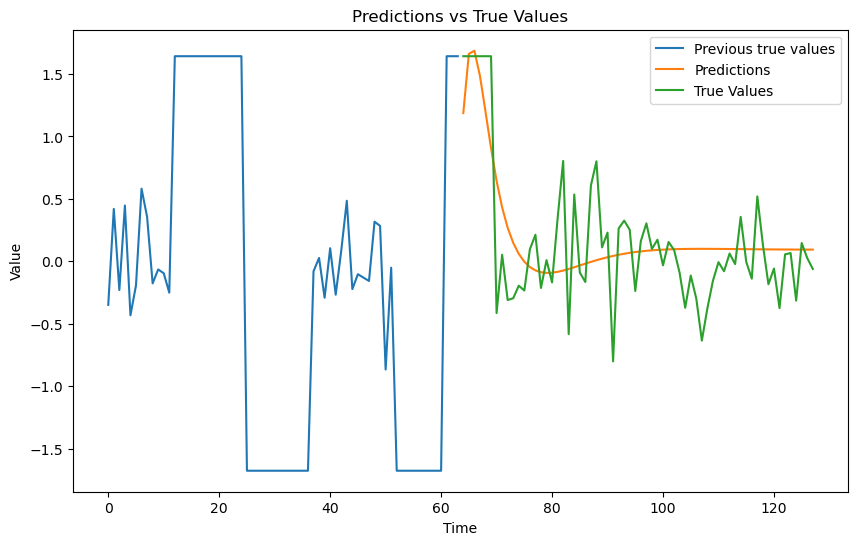

In [20]:
# Plotting the predictions and true values
plt.figure(figsize=(10, 6))
plt.plot(list(range(64)), X_test_input[5,:,0], label='Previous true values')
plt.plot(list(range(64, 128)), predictions[5,:,0], label='Predictions')
plt.plot(list(range(64, 128)), X_test_target[5,:,0], label='True Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predictions vs True Values')
plt.legend()
plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D

def create_forecasting_transformer_model(input_shape, num_layers, d_model, num_heads, dff, output_shape, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = Dense(d_model)(inputs)

    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x, x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(dff, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Adapt the Transformer to output a sequence of the desired length
    x = Dense(output_shape[0])(x)
    outputs = Dense(output_shape[1])(x)  # Assuming a single feature per timestep in the output

    model = Model(inputs, outputs)
    return model

# Example usage for the Transformer model
forecasting_transformer_model = create_forecasting_transformer_model(
    input_shape=X_train_input.shape[1:],
    num_layers=3,
    d_model=64,
    num_heads=4,
    dff=256,
    output_shape=X_train_target.shape[1:],
    dropout_rate=0.1
)
forecasting_transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
forecasting_transformer_model.fit(X_train_input, X_train_target, validation_data=(X_train_target, X_train_input), epochs=20)
forecasting_transformer_model.summary()



Epoch 1/10
32/32 [==============================] - 10s 45ms/step - loss: 2.2872 - mae: 1.1592 - val_loss: 0.7701 - val_mae: 0.6362
Epoch 2/10
32/32 [==============================] - 1s 37ms/step - loss: 1.2433 - mae: 0.8907 - val_loss: 0.7435 - val_mae: 0.6155
Epoch 3/10
32/32 [==============================] - 1s 36ms/step - loss: 1.2336 - mae: 0.8846 - val_loss: 0.7424 - val_mae: 0.6152
Epoch 4/10
32/32 [==============================] - 1s 29ms/step - loss: 1.2278 - mae: 0.8819 - val_loss: 0.7413 - val_mae: 0.6145
Epoch 5/10
32/32 [==============================] - 1s 29ms/step - loss: 1.2272 - mae: 0.8825 - val_loss: 0.7476 - val_mae: 0.6204
Epoch 6/10
32/32 [==============================] - 1s 28ms/step - loss: 1.2251 - mae: 0.8806 - val_loss: 0.7415 - val_mae: 0.6149
Epoch 7/10
32/32 [==============================] - 1s 29ms/step - loss: 1.2231 - mae: 0.8792 - val_loss: 0.7406 - val_mae: 0.6145
Epoch 8/10
32/32 [==============================] - 1s 25ms/step - loss: 1.2196 - 

## Section 3 Comparative Analysis

##### **Comparative Analysis**
- **Local vs. Global Pattern Recognition**: CNNs might outperform other models when the dataset mainly features local, stationary patterns. On the other hand, Transformers might excel by understanding global context and relationships, potentially surpassing LSTMs in understanding longer temporal dependencies.
- **Flexibility and Efficiency**: While LSTMs provide a balanced approach with their adaptability to variable lengths, Transformers' efficiency and parallel processing capabilities present a interesting alternative for large datasets.